In [38]:
# IMPORTING LIBRARIES
import warnings
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from relativeImp import relativeImp
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, plot_partial_dependence
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet

In [39]:
#SETTINGS
warnings.filterwarnings("ignore")

## Data Processing

In [40]:
#READ DATA
sample_data = pd.read_excel('SAMPLE_DATA.xlsx', header = 1)

In [41]:
#EXTRACT EXPLANATION 
explantion = sample_data['Variables']
sample_data = sample_data.drop(['Variables'], axis=1)

In [42]:
#TRANSPOSE DATA
transpose_sample_data = sample_data.T

In [43]:
#ADD HEADER
main_data = transpose_sample_data.rename(columns=transpose_sample_data.iloc[0]).drop(transpose_sample_data.index[0])

In [44]:
main_data.index = pd.to_datetime(main_data.index)

In [45]:
main_df = main_data.astype(float)

In [46]:
main_df['Date']= main_df.index
main_df['Month']= main_df.index.month
main_df['Year']= main_df.index.year
main_df['week_number'] = main_df.index.isocalendar().week

In [47]:
main_df.head(5)

,BRAND_A_VOLUME,BRAND_A_PRICE,COMPETITOR_A_PRICE,COMPETITOR_B_PRICE,COMPETITOR_C_PRICE,COMPETITOR_D_PRICE,COMPETITOR_E_PRICE,BRAND_A_New product,COMPETITOR_New product,BRAND_A_Insert,COMPETITOR_A_Insert,COMPETITOR_B_Insert,COMPETITOR_C_Insert,COMPETITOR_D_Insert,BRAND_A_Redemption,COMPETITOR_B_Redemption,COMPETITOR_C_Redemption,COMPETITOR_D_Redemption,Kurban_Bayrami,Ramazan_Bayrami,Anneler_Gunu,Babalar_Gunu,Sevgililier_Günü,Yilbasi,Special_Day1,Special_Day2,Kadınlar_Günü,BRAND_A_TOTAL_GRP,BRAND_A_ Total_Digital_Spending,BRAND_A_OTHER_CATEGORY_1_GRP,BRAND_A_OTHER_CATEGORY_2_GRP,COMPETITOR_B_TOTAL_GRP,COMPETITOR_C_TOTAL_GRP,COMPETITOR_D_TOTAL_GRP,COMPETITOR_E_TOTAL_GRP,COMPETITOR_F_TOTAL_GRP,Real_Private_Consumption,BRAND_A_NDP,Teshir_Orani_BRAND_A,Date,Month,Year,week_number
2016-05-02,35232.8,12.593379,11.89,15.37,13.35,11.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,15065.24,0.0,72.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0,2016-05-02,5,2016,18
2016-05-09,155680.4,9.306888,9.51,9.65,9.94,8.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.59,9386.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0,2016-05-09,5,2016,19
2016-05-16,34356.6,12.539075,12.14,15.17,13.04,11.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137.83,10038.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0,2016-05-16,5,2016,20
2016-05-23,34145.7,12.915243,12.69,15.61,13.49,11.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.48,9449.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0,2016-05-23,5,2016,21
2016-05-30,35328.5,12.678149,12.31,15.47,13.67,12.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.16,10151.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,964.074,0.0,0.0,2016-05-30,5,2016,22


In [48]:
main_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BRAND_A_VOLUME,161.0,72387.690683,39921.647218,29844.900000,44946.800000,58236.300000,84802.700000,238295.000000
BRAND_A_PRICE,161.0,12.748850,1.993461,8.037141,11.539570,12.709268,13.738464,19.582928
COMPETITOR_A_PRICE,161.0,13.772484,2.660664,7.520000,11.950000,13.250000,15.550000,20.810000
COMPETITOR_B_PRICE,161.0,15.565776,3.118428,9.120000,13.480000,15.470000,17.010000,23.920000
COMPETITOR_C_PRICE,161.0,18.278820,5.054676,9.940000,13.850000,18.390000,20.740000,32.220000
COMPETITOR_D_PRICE,161.0,12.980124,2.566174,8.360000,11.040000,12.950000,14.210000,20.150000
COMPETITOR_E_PRICE,161.0,4.796957,9.562911,0.000000,0.000000,0.000000,0.000000,29.750000
BRAND_A_New product,161.0,0.173913,0.380217,0.000000,0.000000,0.000000,0.000000,1.000000
COMPETITOR_New product,161.0,0.161491,0.369131,0.000000,0.000000,0.000000,0.000000,1.000000
BRAND_A_Insert,161.0,0.402137,0.417014,0.000000,0.000000,0.242965,0.693923,1.526836


### Correlation HeatMap

Pearson’s correlation coefficient is the test statistics that measures the statistical relationship, or association, between two continuous variables.  It is known as the best method of measuring the association between variables of interest because it is based on the method of covariance.  It gives information about the magnitude of the association, or correlation, as well as the direction of the relationship.

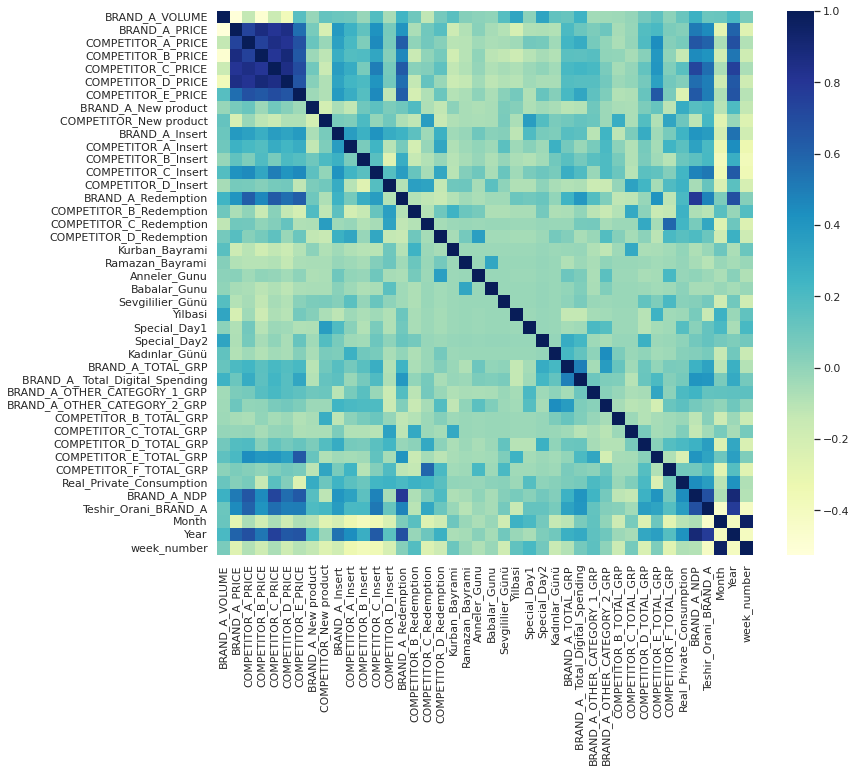

In [49]:
corr = main_df.corr()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(corr,cmap="YlGnBu")

* It is obvious that sales are inversely related to prices.
* Prices decrease on holidays.
* As the number of months increases, the rate of entering store magazines decreases.

### Key-Driver Analysis

Key Driver Analysis is a methodology branded in market research, called Relative Weights Analysis in Data Science (which can be either Shapley or Johnson's method). Key Drivers Analysis identifies how much each of the predictor variables (the drivers) are moving the depentor variable (key metric, key performance indicator aka KPI). In other words, "what are the drivers of your key metric?"

Relative importance or relative weight analysis is a method to “partition explained variance among multiple predictors to better understand the role played by each predictor in a regression equation” [(Tonidandel & LeBreton, 2011)](https://www.scotttonidandel.com/rwa-web). 

As drivers are often highly correlated with each other, typical multiple regression analysis would produce flawed indicators of driver importance. Instead, we adopt the relative weight analysis approach which accurately partitions variance among the correlated drivers.

In [50]:
yName =  'BRAND_A_VOLUME'

xNames = ['BRAND_A_PRICE', 'COMPETITOR_A_PRICE', 'COMPETITOR_B_PRICE',
       'COMPETITOR_C_PRICE', 'COMPETITOR_D_PRICE', 'COMPETITOR_E_PRICE',
       'BRAND_A_New product', 'COMPETITOR_New product', 'BRAND_A_Insert',
       'COMPETITOR_A_Insert', 'COMPETITOR_B_Insert',
       'COMPETITOR_C_Insert', 'COMPETITOR_D_Insert', 'BRAND_A_Redemption',
       'COMPETITOR_B_Redemption', 'COMPETITOR_C_Redemption',
       'COMPETITOR_D_Redemption', 'Kurban_Bayrami', 'Ramazan_Bayrami',
       'Anneler_Gunu', 'Babalar_Gunu', 'Sevgililier_Günü', 'Yilbasi',
       'Special_Day1', 'Special_Day2', 'Kadınlar_Günü',
       'BRAND_A_TOTAL_GRP', 'BRAND_A_ Total_Digital_Spending',
       'BRAND_A_OTHER_CATEGORY_1_GRP', 'BRAND_A_OTHER_CATEGORY_2_GRP',
       'COMPETITOR_B_TOTAL_GRP', 'COMPETITOR_C_TOTAL_GRP',
       'COMPETITOR_D_TOTAL_GRP', 'COMPETITOR_E_TOTAL_GRP',
       'COMPETITOR_F_TOTAL_GRP', 'Real_Private_Consumption',
       'BRAND_A_NDP', 'Teshir_Orani_BRAND_A','week_number']

results = relativeImp(main_df, outcomeName = yName, driverNames = xNames)
sorted_result = results.sort_values(by=['rawRelaImpt','normRelaImpt'],ascending=False)
sorted_result.iloc[:10]

,driver,rawRelaImpt,normRelaImpt
0,BRAND_A_PRICE,0.152757,17.106162
2,COMPETITOR_B_PRICE,0.116101,13.001355
4,COMPETITOR_D_PRICE,0.077311,8.657538
3,COMPETITOR_C_PRICE,0.050786,5.687146
13,BRAND_A_Redemption,0.048667,5.449823
36,BRAND_A_NDP,0.047791,5.351804
22,Yilbasi,0.047280,5.294563
24,Special_Day2,0.044947,5.033300
5,COMPETITOR_E_PRICE,0.042992,4.814375
1,COMPETITOR_A_PRICE,0.040450,4.529698


What is a good R-squared?
* <.3 is not good
* .3 - .4 is normal
* .4 - .5 is great
* .5 - .6 is exceptional
* \>.6 is dangerously high, possibly overfitting

In [51]:
print("R-SQUARED:"+str(sum(sorted_result[:6].rawRelaImpt) ))

R-SQUARED:0.4934133028201161


In [52]:
print('Key Sales Drivers:')
print(sorted_result[:6].driver)

Key Sales Drivers:
0          BRAND_A_PRICE
2     COMPETITOR_B_PRICE
4     COMPETITOR_D_PRICE
3     COMPETITOR_C_PRICE
13    BRAND_A_Redemption
36           BRAND_A_NDP
Name: driver, dtype: object


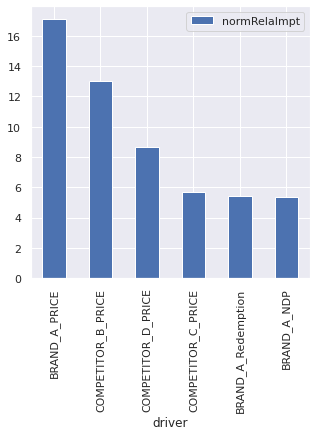

In [53]:
sns.set(rc={'figure.figsize':(5,5)})
ax = sorted_result[:6][['driver','normRelaImpt']].plot.bar(x='driver',rot=90)

We see the Key Sales Drivers for brand A in the graphic above. Of course, the most important factor affecting the sales of brand A is the prices of its competitors and itself. As a result, the priority issue for brand A is to determine the price strategy. It is very important both to keep the profit at the right level and to set a competitive price.

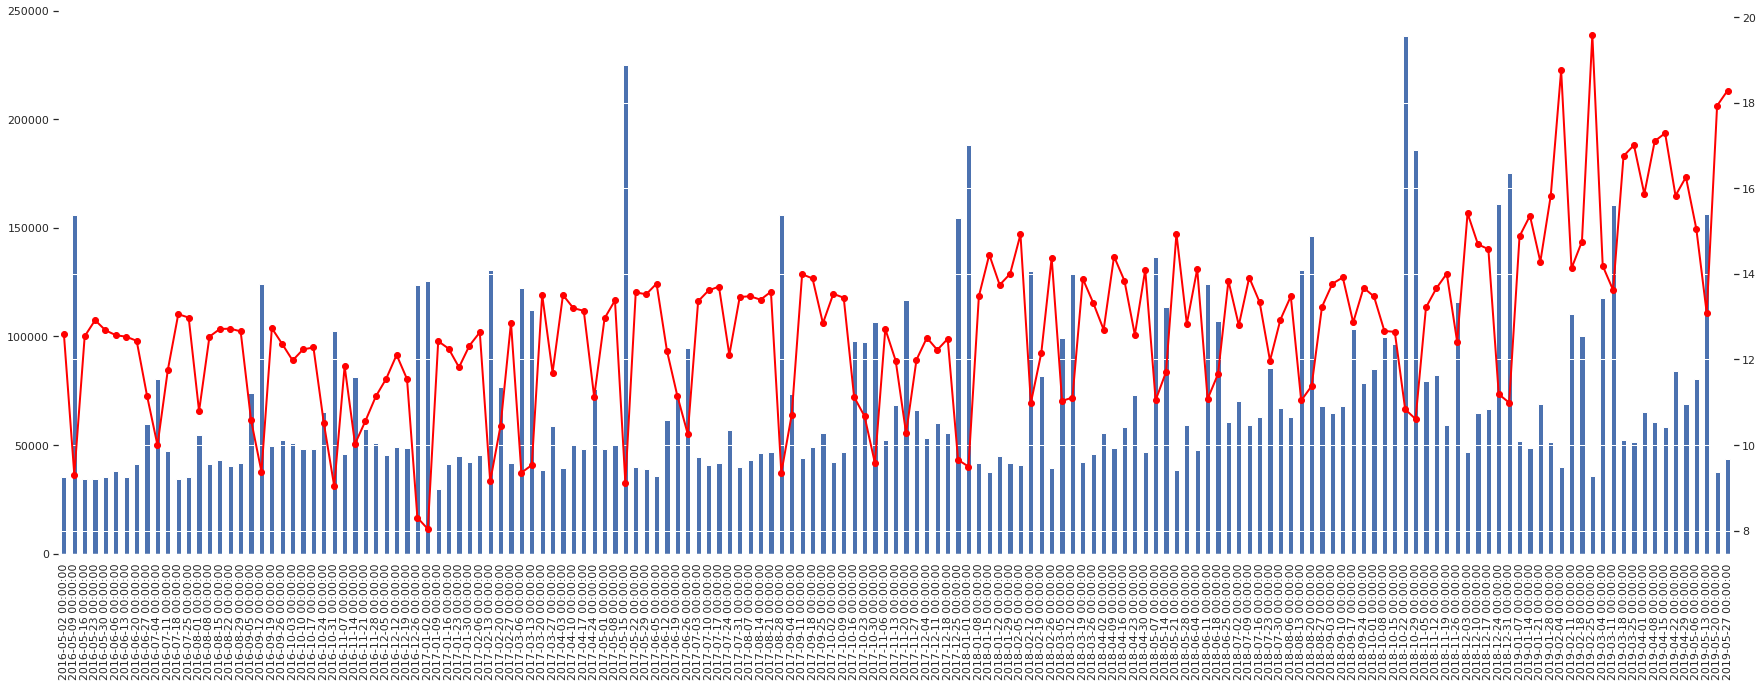

In [54]:
sns.set(rc={'figure.figsize':(30,10)})
fig = plt.figure()

ax = main_df['BRAND_A_VOLUME'].plot(kind='bar', use_index=True)
ax.patch.set_facecolor('white')
ax.patch.set_alpha(0.0)
ax2 = ax.twinx()
ax2.plot(main_df['BRAND_A_PRICE'].values, linestyle='-', marker='o', linewidth=2.0, color='red')

We see a graph of the most important Key Sales Driver. We see the sales volume over time in the bar chart, and the change in the price of the brand A in the line chart. **We clearly see that the most important reason for the increase in sales is the decrease in prices.**

## Feature Interactions

If a machine learning model makes a prediction based on two features, we can decompose the prediction into four terms: a constant term, a term for the first feature, a term for the second feature and a term for the interaction between the two features.
The interaction between two features is the change in the prediction that occurs by varying the features after considering the individual feature effects.

In [55]:
y = main_df['BRAND_A_VOLUME']
X = main_df.drop(['BRAND_A_VOLUME','Date','Month','Year','week_number'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [56]:
gbr_1 = GradientBoostingRegressor(random_state = 137)
gbr_1.fit(X_train, y_train)
gbr_1.score(X_test, y_test)

0.6777605254224552

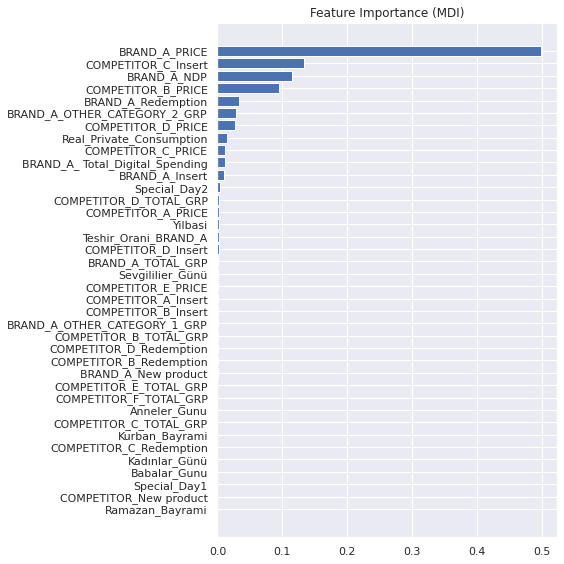

In [57]:
feature_importance = gbr_1.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5 
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(xNames)[sorted_idx])
plt.title('Feature Importance (MDI)')
fig.tight_layout()
plt.show()

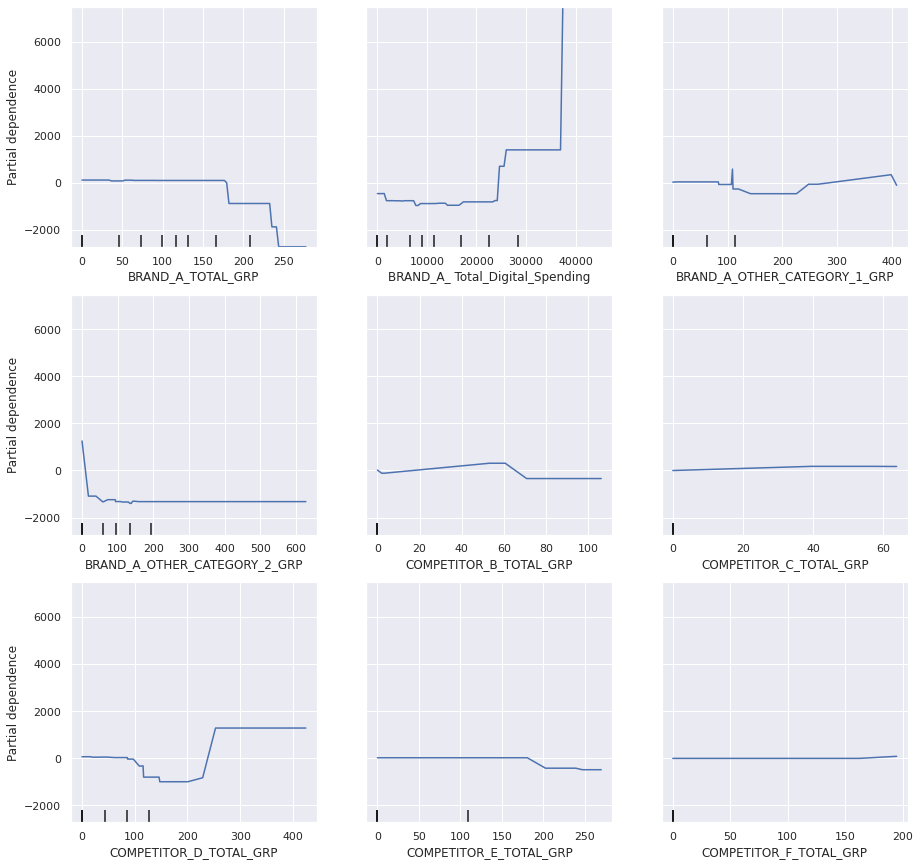

In [62]:
sns.set(rc={'figure.figsize':(15,15)})
plot_partial_dependence(gbr_1, X_train, [26,27,28,29,30,31,32,33,34])

We see graphs showing how marketing data interacts with sales volume. We see that values below 0 in the graphs correspond to a result below the average value of the feature in y for that value of the feature in x.

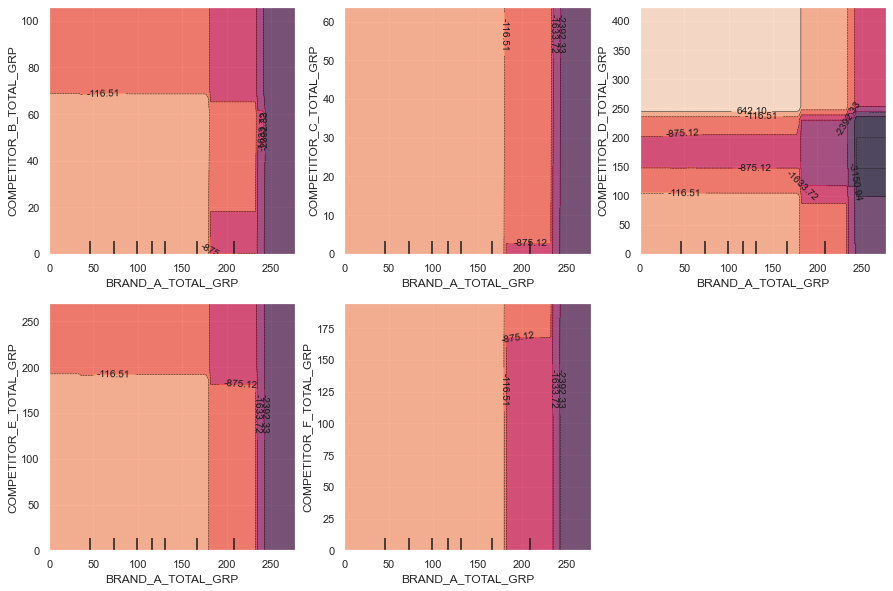

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
plot_partial_dependence(gbr_1, X_train, [(26, 30), (26, 31), (26, 32), (26, 33), (26, 34)])

Graphics showing how GRP features affect sales volume and how the Total GRP value of brand A is in synergy with other brands' GRPs. Light color means high sales volume.

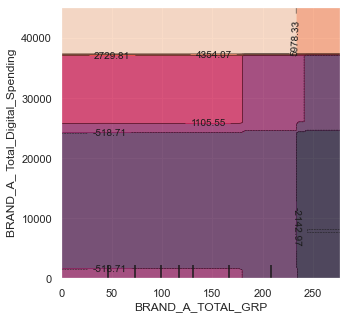

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
plot_partial_dependence(gbr_1, X_train, [(26, 27)])

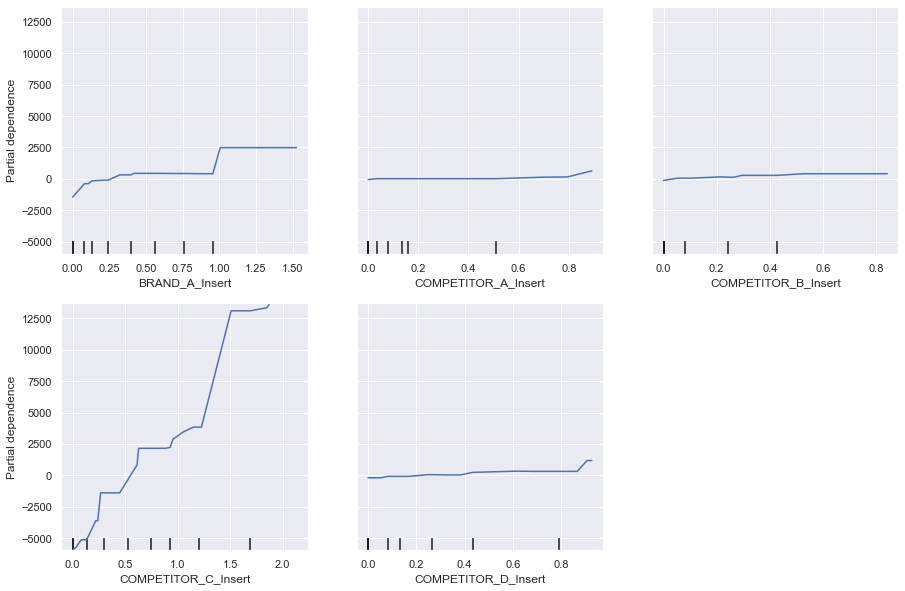

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
plot_partial_dependence(gbr_1, X_train, [8,9,10,11,12])

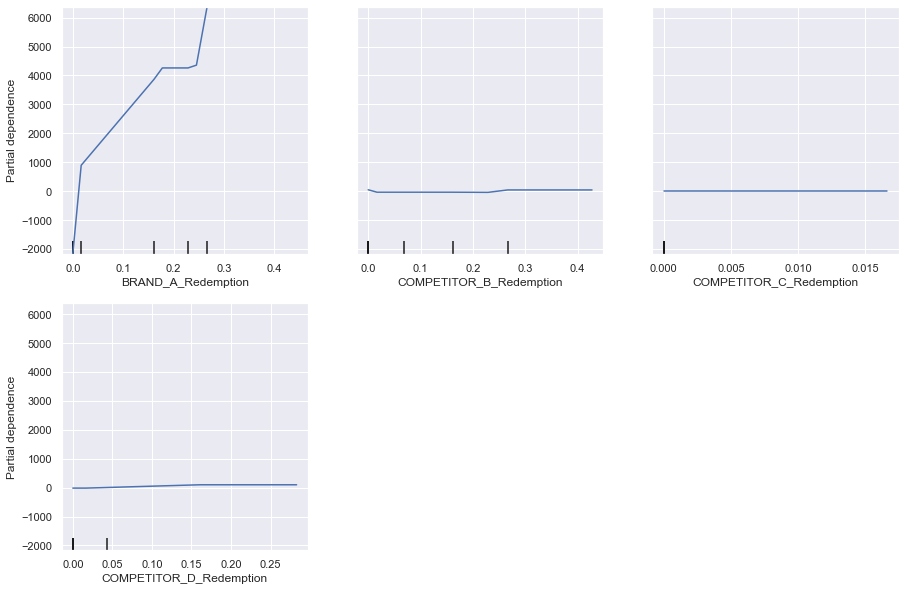

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
plot_partial_dependence(gbr_1, X_train, [13,14,15,16])

* We cannot say that there is an interaction between the discounts of other brands and the sales volume of brand A.

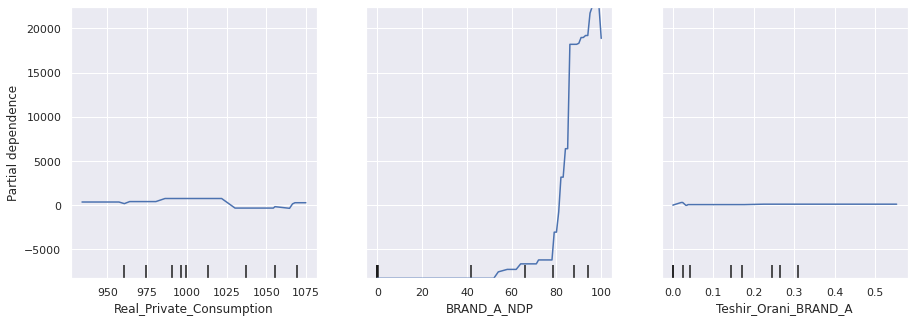

In [65]:
sns.set(rc={'figure.figsize':(15,5)})
plot_partial_dependence(gbr_1, X_train, [35,36,37])

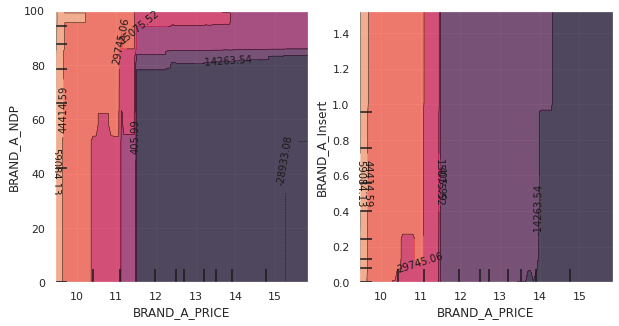

In [68]:
sns.set(rc={'figure.figsize':(10,5)})
plot_partial_dependence(gbr_1, X_train, [(0,36),(0,8)])

* As can be seen, the graphs become darker as the price increases in the graphs of the A brand price.
* When we look at the graph of the number of products and price interaction, if the number of products is high, the sales do not decrease even if the price is high.

## Price Elasticity

Most customers in most markets are sensitive to the price of a product or service, and the assumption is that more people will buy the product or service if it’s cheaper and less will buy it if it’s more expensive. But the phenomenon is more quantifiable than that, and price elasticity shows exactly how responsive customer demand is for a product based on its price.

This is the formula for price elasticity of demand:

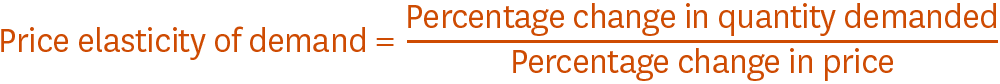

In [ ]:
#CALCULATE PRICE ELASTICITY
main_df['Elasticity'] = np.nan 

for i in range(1,len(main_df)):
  Q = (main_df['BRAND_A_VOLUME'][i] - main_df['BRAND_A_VOLUME'][i-1]) / ((main_df['BRAND_A_VOLUME'][i] + main_df['BRAND_A_VOLUME'][i-1]))/2 * 100
  P = (main_df['BRAND_A_PRICE'][i] - main_df['BRAND_A_PRICE'][i-1]) / ((main_df['BRAND_A_PRICE'][i] + main_df['BRAND_A_PRICE'][i-1]))/2 * 100
  main_df['Elasticity'][i] = Q / P

<AxesSubplot:>

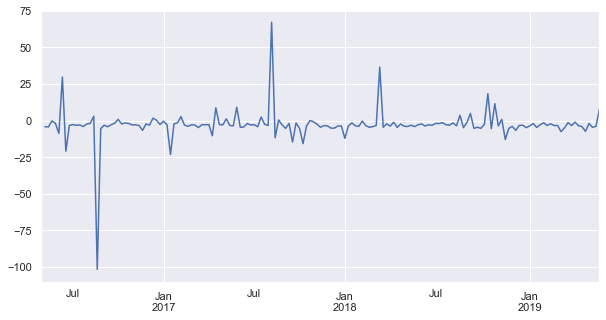

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
main_df['Elasticity'].plot()

In [ ]:
main_df.sort_values(by=['Elasticity'],ascending=True).head()

,BRAND_A_VOLUME,BRAND_A_PRICE,COMPETITOR_A_PRICE,COMPETITOR_B_PRICE,COMPETITOR_C_PRICE,COMPETITOR_D_PRICE,COMPETITOR_E_PRICE,BRAND_A_New product,COMPETITOR_New product,BRAND_A_Insert,...,COMPETITOR_E_TOTAL_GRP,COMPETITOR_F_TOTAL_GRP,Real_Private_Consumption,BRAND_A_NDP,Teshir_Orani_BRAND_A,Date,Month,Year,week_number,Elasticity
2016-08-22,40577.8,12.716313,12.42,14.66,13.11,10.73,0.0,0.0,0.0,0.000000,...,0.0,0.0,947.444,0.0,0.000000,2016-08-22,8,2016,34,-101.636643
2017-01-16,41500.1,12.250573,12.59,16.87,11.08,12.74,0.0,0.0,1.0,0.588280,...,0.0,0.0,998.167,0.0,0.158412,2017-01-16,1,2017,3,-23.211817
2016-06-20,41407.9,12.432410,12.75,14.50,13.95,11.53,0.0,0.0,0.0,0.000000,...,0.0,0.0,974.061,0.0,0.000000,2016-06-20,6,2016,25,-20.895045
2017-10-09,46689.1,13.439968,14.72,14.88,18.92,13.26,0.0,1.0,0.0,0.399940,...,0.0,0.0,1042.368,37.0,0.032240,2017-10-09,10,2017,41,-15.715699
2017-09-18,49057.5,13.889823,12.82,15.18,21.30,13.51,0.0,0.0,0.0,0.439775,...,0.0,0.0,1030.321,28.0,0.177399,2017-09-18,9,2017,38,-14.625730


In [ ]:
main_df.loc['2016-08-15':'2016-08-23',:]

,BRAND_A_VOLUME,BRAND_A_PRICE,COMPETITOR_A_PRICE,COMPETITOR_B_PRICE,COMPETITOR_C_PRICE,COMPETITOR_D_PRICE,COMPETITOR_E_PRICE,BRAND_A_New product,COMPETITOR_New product,BRAND_A_Insert,...,COMPETITOR_E_TOTAL_GRP,COMPETITOR_F_TOTAL_GRP,Real_Private_Consumption,BRAND_A_NDP,Teshir_Orani_BRAND_A,Date,Month,Year,week_number,Elasticity
2016-08-15,42929.3,12.709268,13.25,15.22,13.34,10.59,0.0,0.0,0.0,0.0,...,0.0,0.0,947.444,0.0,0.0,2016-08-15,8,2016,33,2.956353
2016-08-22,40577.8,12.716313,12.42,14.66,13.11,10.73,0.0,0.0,0.0,0.0,...,0.0,0.0,947.444,0.0,0.0,2016-08-22,8,2016,34,-101.636643


When we examine the data of the week with the lowest Price Elasticity value, we see that the sales decreased considerably despite a very small increase in price. If we try to interpret the reasons for this, we see that we have:

* In the week in which the price of Brand A increased, the other 3 competitors (Competitor A, B, C) decreased considerably in their prices. This suggests that customers are more likely to switch to other companies.
* Competitor D brand, which increased its price together with the A brand, is quite higher than the other companies as TOTAL_GRP that week. This may have affected the A brand as a negative sales return in terms of visibility.

In [ ]:
main_df.loc['2017-08-01':'2017-08-15',:]

,BRAND_A_VOLUME,BRAND_A_PRICE,COMPETITOR_A_PRICE,COMPETITOR_B_PRICE,COMPETITOR_C_PRICE,COMPETITOR_D_PRICE,COMPETITOR_E_PRICE,BRAND_A_New product,COMPETITOR_New product,BRAND_A_Insert,...,COMPETITOR_E_TOTAL_GRP,COMPETITOR_F_TOTAL_GRP,Real_Private_Consumption,BRAND_A_NDP,Teshir_Orani_BRAND_A,Date,Month,Year,week_number,Elasticity
2017-08-07,43275.0,13.474292,14.18,15.38,19.19,14.04,0.0,0.0,0.0,0.560487,...,0.0,0.0,1021.9,3.0,0.109316,2017-08-07,8,2017,32,67.209841
2017-08-14,46447.7,13.393559,14.38,15.49,19.39,13.78,0.0,0.0,0.0,0.560487,...,0.0,0.0,1021.9,3.0,0.109316,2017-08-14,8,2017,33,-11.768080


When we examine the data of the week with the highest Price Elasticity value, we see that the sales have increased considerably despite the slight decrease in the price. If we try to interpret the reasons for this, we see that we have:

* In the week that brand A lowered its price, the prices of its other 3 competitors (Compatitor A, B, C) increased. This may have affected sales.
* In addition, the GRP value of brand A for that week is higher than other companies, that is, TV advertisements can be effective in increasing sales.

In [ ]:
x_value = main_df['BRAND_A_PRICE']
y_value = main_df['BRAND_A_VOLUME']
X = sm.add_constant(x_value)
model = sm.OLS(y_value, X)
result = model.fit()
    
if result.f_pvalue < 0.05:
  intercept, slope = result.params
  mean_price = np.mean(x_value)
  mean_quantity = np.mean(y_value)
  price_elasticity = (slope)*(mean_price/mean_quantity)

In [ ]:
price_elasticity

-1.8480593275680002

According to the general average, the price elasticity of brand A is -1.84. In other words, against a 1% price increase, sales numbers decrease by 1.84%.

## Optimum Price Index

Price Index is the metric that shows your price positioning in the market. We’ll talk about how observing the price index helps in improving sales, controlling the positioning of your brand, and finding loopholes to rise among competitors.

For a single product and competitor, it’s quite simple.

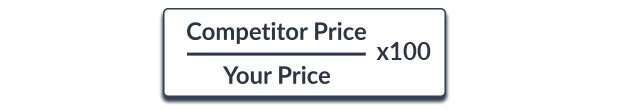

Divide the competitor’s price by yours and multiply it by 100.

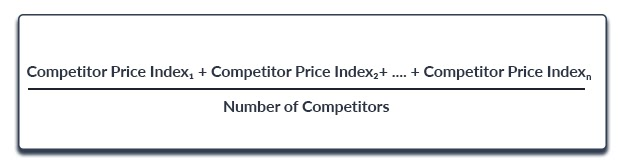

In [16]:
prices = main_df[['BRAND_A_PRICE', 'COMPETITOR_A_PRICE', 'COMPETITOR_B_PRICE',
       'COMPETITOR_C_PRICE', 'COMPETITOR_D_PRICE','COMPETITOR_E_PRICE','BRAND_A_VOLUME']]

In [17]:
#The price information of the E brand came after a certain period of time.
prices['Competitor_Count'] = 4
prices.loc['2018-10-09':,'Competitor_Count'] = 5

In [18]:
PI = (((prices.iloc[:,1]/prices.iloc[:,0])
     + (prices.iloc[:,2]/prices.iloc[:,0])
     + (prices.iloc[:,3]/prices.iloc[:,0])
     + (prices.iloc[:,4]/prices.iloc[:,0])
     + (prices.iloc[:,5]/prices.iloc[:,0]))*100) / prices.iloc[:,7]

In [19]:
prices['BRAND_A_PI'] = (prices.iloc[:,0]/prices.iloc[:,0])*100 
prices['COMPETITOR_A_PI'] = (prices.iloc[:,1]/prices.iloc[:,0])*100 
prices['COMPETITOR_B_PI'] = (prices.iloc[:,2]/prices.iloc[:,0])*100 
prices['COMPETITOR_C_PI'] = (prices.iloc[:,3]/prices.iloc[:,0])*100 
prices['COMPETITOR_D_PI'] = (prices.iloc[:,4]/prices.iloc[:,0])*100 
prices['COMPETITOR_E_PI'] = (prices.iloc[:,5]/prices.iloc[:,0])*100 
prices['PI'] = PI

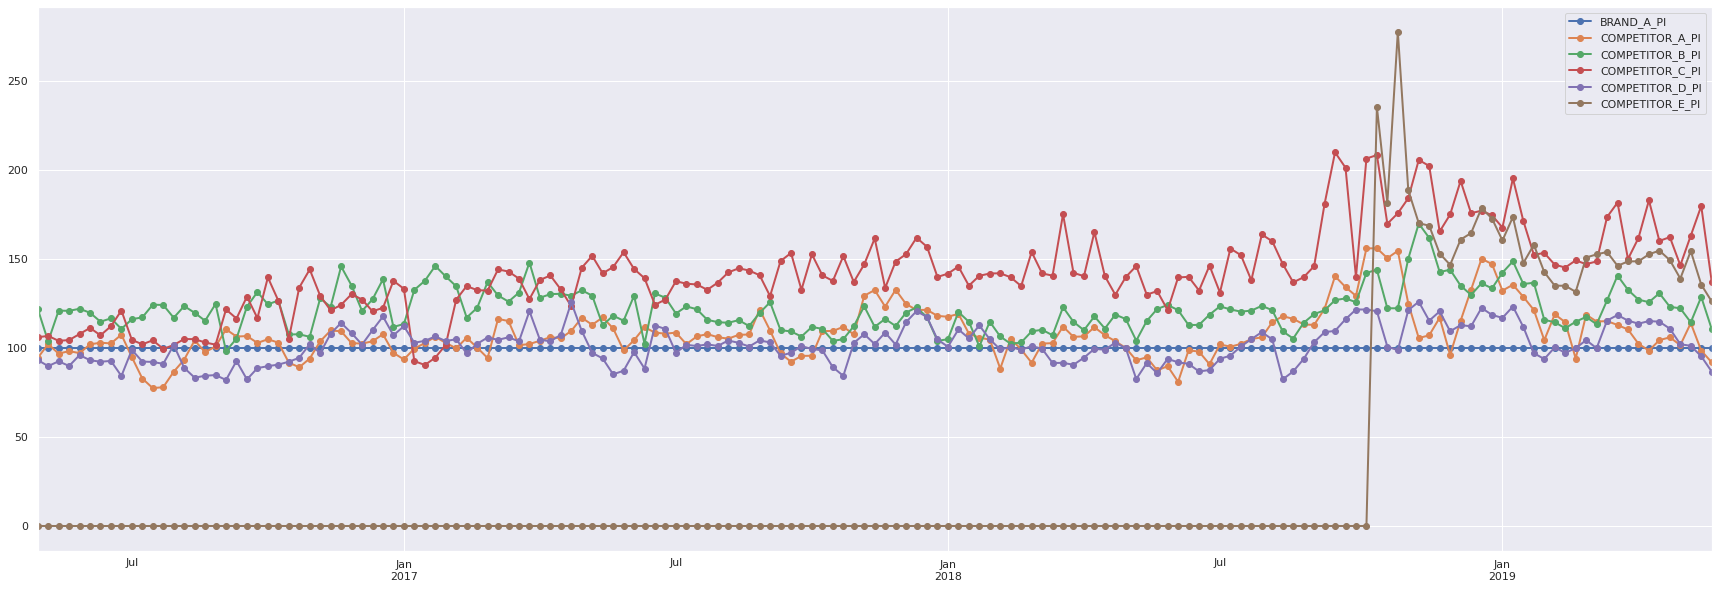

In [20]:
sns.set(rc={'figure.figsize':(30,10)})
prices[['BRAND_A_PI','COMPETITOR_A_PI','COMPETITOR_B_PI','COMPETITOR_C_PI','COMPETITOR_D_PI','COMPETITOR_E_PI']].plot(linestyle='-', marker='o', linewidth=2.0)

This chart shows us the price index of brand A relative to its competitors. **As you can see in the chart, brand A usually has a pricing strategy at market average or below market.**

In [21]:
main_df['Special_Day'] = main_df[['Kurban_Bayrami', 'Ramazan_Bayrami',
       'Anneler_Gunu', 'Babalar_Gunu', 'Sevgililier_Günü', 'Yilbasi',
       'Special_Day1', 'Special_Day2', 'Kadınlar_Günü']].sum(axis=1)

In [22]:
main_df['color'] = main_df['Special_Day'].apply(lambda x: 'green' if x==1 else 'red')

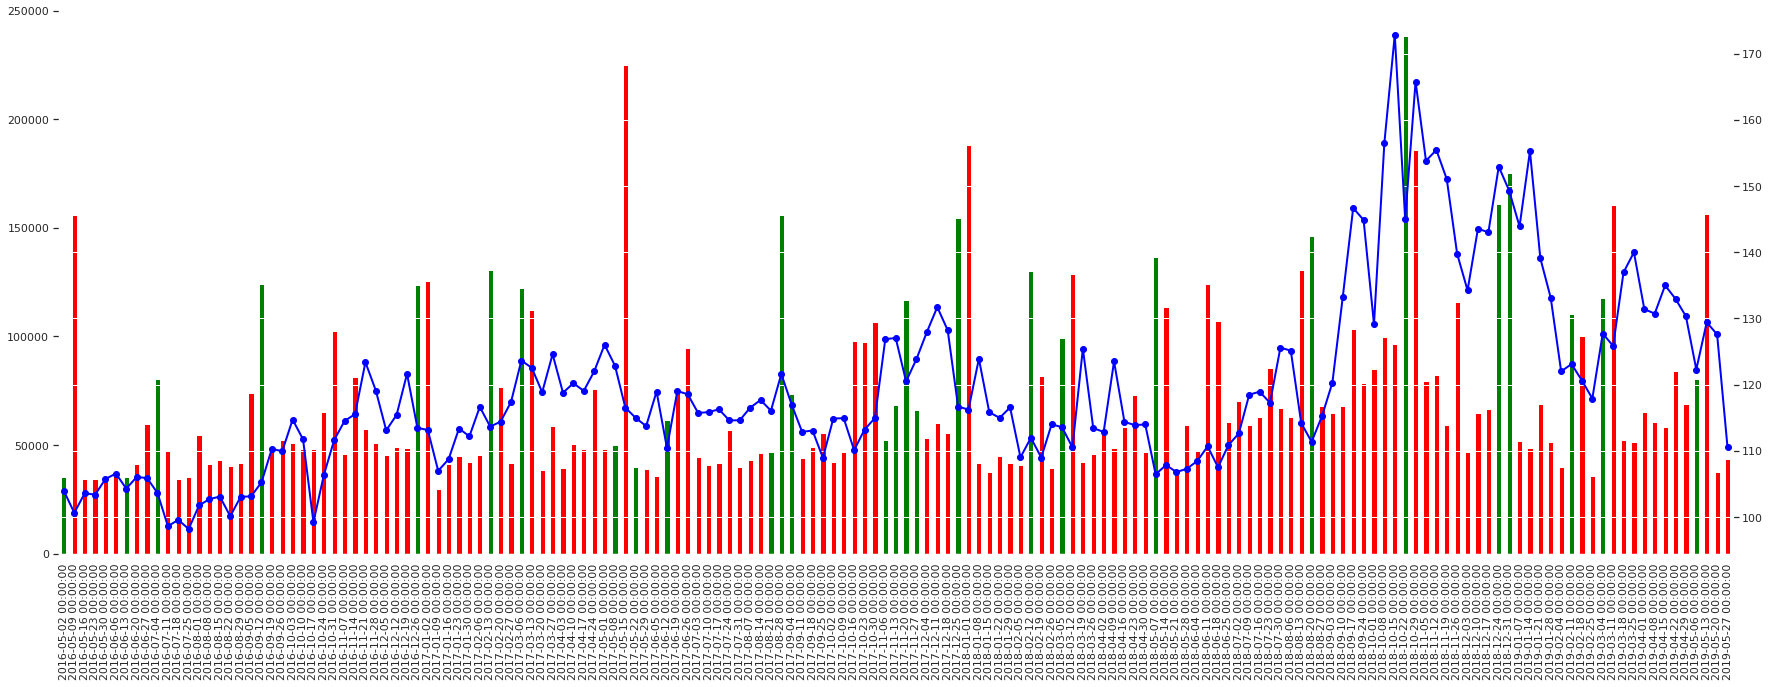

In [25]:
sns.set(rc={'figure.figsize':(30,10)})
fig = plt.figure()

ax = prices['BRAND_A_VOLUME'].plot(kind='bar', use_index=True,color=main_df['color'].values)
ax.patch.set_facecolor('white')
ax.patch.set_alpha(0.0)
ax2 = ax.twinx()
ax2.plot(prices['PI'].values, linestyle='-', marker='o', linewidth=2.0, color='blue')

We see a 3D graph. The bar graph shows the sales volume, the color of the bar graph shows the special days, the line graph shows the competitive price index. Where the price index falls, there are 2 options: the first is to increase the price of brand A, and the second is to decrease the price of competitor brands.

## Forecast

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.[1](https://facebook.github.io/prophet/)

In [26]:
df = main_df[['BRAND_A_VOLUME']] 
df['Date'] = main_df.index 
df = df[['Date','BRAND_A_VOLUME']]

In [27]:
df = df.reset_index().drop(['index'],axis=1)
df.columns = ['ds', 'y']

In [28]:
threshold_date = pd.to_datetime('2018-12-10')
mask = df['ds'] < threshold_date
df_train = df[mask][['ds', 'y']]
df_test = df[~ mask][['ds', 'y']]

In [29]:
def create_holidays_df():
  """
  DESC: Create a holidays dataframe.
  
  INPUT: No Input.

  OUTPUT: Dataframe 
  """
  holidays = pd.DataFrame({
      'holiday': 'end_of_year',
      'ds': pd.to_datetime(
          ['2016-05-02', '2016-06-13', '2016-07-04', '2016-09-12',
               '2016-12-26', '2017-02-13', '2017-03-06', '2017-05-08',
               '2017-05-22', '2017-06-12', '2017-08-21', '2017-08-28',
               '2017-09-04', '2017-11-06', '2017-11-13', '2017-11-20',
               '2017-11-27', '2017-12-25', '2018-02-12', '2018-03-05',
               '2018-05-07', '2018-08-20', '2018-10-22', '2018-12-24',
               '2018-12-31', '2019-02-11', '2019-03-04', '2019-05-06']
      ),
      'lower_window': -7,
      'upper_window': 7,
    })
  return holidays

In [30]:
def build_model():
  """
  DESC: Create a Forecast model.

  INPUT: No Input.

  OUTPUT: Forecast Model
  """
  holidays = create_holidays_df()
    
  model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        holidays = holidays, 
        interval_width=0.95, 
        mcmc_samples = 500
    )

  model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )
    
  return model
    
model = build_model()

In [31]:
model.fit(df_train)

In [32]:
forecast = model.predict(df=df_test)

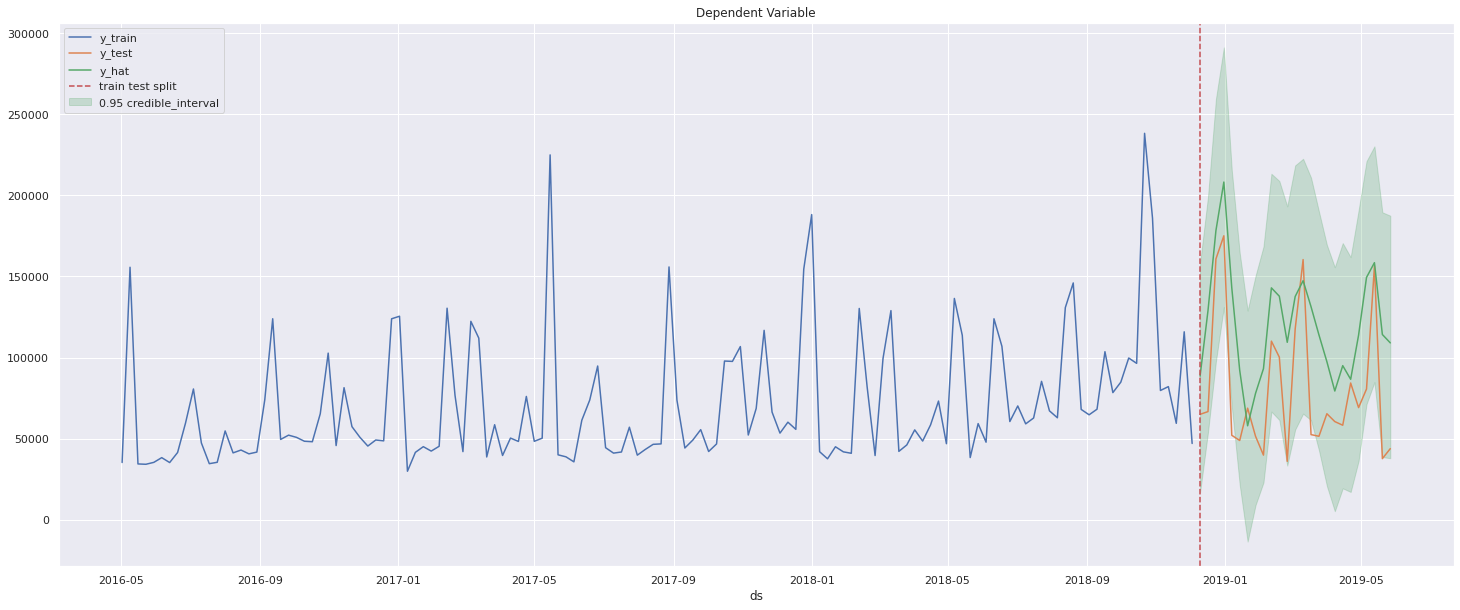

In [ ]:
sns.set(rc={'figure.figsize':(25,10)})
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)
sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

In [33]:
metrics = pd.merge(forecast[['ds','yhat']], df_test, on='ds', how='inner')

In [37]:
r2 = r2_score(metrics.y, metrics.yhat)
print("R2 Score: ",r2)

R2 Score:  -0.3712448381010087


In [35]:
def MAPE(Y_actual,Y_Predicted):
    """
    DESC: Statistical measure to define the accuracy of a machine learning algorithm.

    INPUT: Actual and Predict Values.

    OUTPUT: Mape value, Float.
    """
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [36]:
FR_MAPE = MAPE(metrics.y, metrics.yhat)
print("MAPE: ",FR_MAPE)

MAPE:  74.65477064734058


In [ ]:
def predict_dates(num_prediction):
  """
  DESC: Create Prediction Days DataFrame.

  INPUT: Prediction Days Number

  OUTPUT: DataFrame
  """
  last_date = df['ds'].values[-1]
  prediction_dates = pd.date_range(last_date, periods=num_prediction+1, freq = 'W').tolist()
  return prediction_dates
  
num_prediction = 25
future = predict_dates(num_prediction)

In [ ]:
future = pd.DataFrame(pd.to_datetime(future),columns=['ds'])
future['ds'] = future['ds'] + timedelta(days=1)

In [ ]:
forecast = model.predict(df=future)

In [ ]:
mask2 = forecast['ds'] < threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

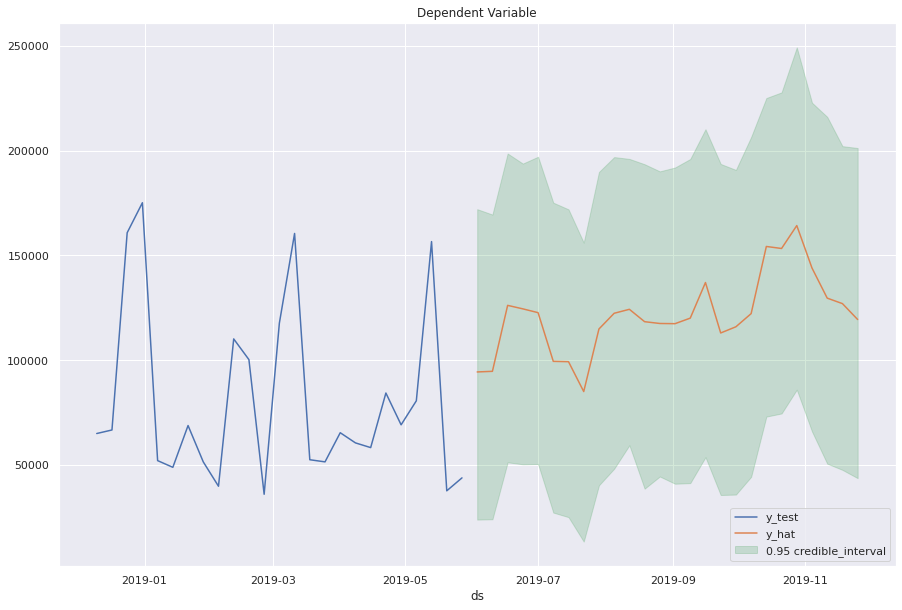

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

In [ ]:
next_6_month = forecast[['ds','yhat']]
next_6_month['month'] = next_6_month['ds'].dt.month

In [ ]:
next_6_month = next_6_month.groupby(by=['month']).sum()

Text(0, 0.5, 'Forecast')

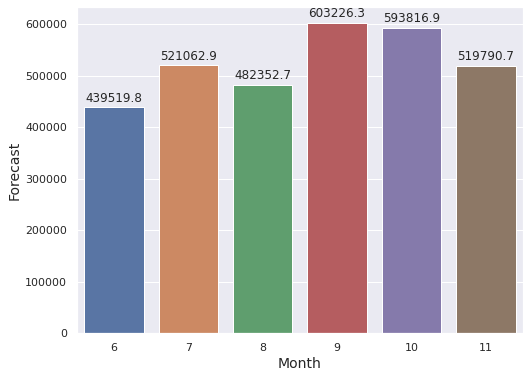

In [ ]:
plt.figure(figsize=(8, 6))
next_6_month = next_6_month.reset_index()
splot=sns.barplot(x="month",y="yhat",data=next_6_month)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Month", size=14)
plt.ylabel("Forecast", size=14)